# Preprocessing Experiments

In [2]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

In [ ]:
datasets = [
    "kapillondhe/american-sign-language",
    "ayuraj/asl-dataset"
]

In [ ]:
for dataset in datasets:
    path = kagglehub.dataset_download(dataset)
    print("Downloaded", path)
    

## Problems/Challenges
- Dataset only consisting of hands with white skin
- Dataset only consisting of white/uniform background
- Some signs in ASL are very similar, e.g. they are equal in the relative position of the hand/fingers, but the rotation is slightly differen. Thus some data augmentations like rotation can't be used for all signs.
- The dataset(s) only contain images of right handed sign language
- To train our model to recognize "white" hands in front of white backgrounds we assume we would have enough data, however we don't have enough data for a more generalized model.

## Solutions
- Data augmentation
- Finetuning an existing image recoginition model

### Data Augmentation

#### Biased Skin Color
**Augmentation**

We could generate new images by transforming the HSV/RGB values of the hands in our existing dataset to HSV/RGB values of hands with different skin color.

**Histogram Matching**

Could use the color distribution of different skin tones and match our dataset with it.

**Edge Detection**

We could also use an edge detection filter to try and preprocess the to make it independent from the skin color.

#### Biased Background
**Substitute the Background**

Could apply a HSV filter to our images to cut out the hand and replace the background with random values or random background images from the internet.

**Diverse Filters**

Could apply blur and other filters to make the learning less susceptible to noise.

#### Combined
**Gray Scale Images**

Could we work with gray scaled images to reduce the dependency on the background as well as on the skin color.

#### Similar Signs
We can't solve the problem that some signs are similar, but we can try to make the distinction between the similar signs as clear as possible by not "augmenting" one sign into the other. We have to pay attention for the following signs:

- I vs. J: J is the same sign as I, but with a slight motion. We are bound to run into a problem here. But we can define I as being an upright pinky finger and J being the one that is in a range of other positions.

The other signs are distinguishable from each other, however M, N, S, T and A are very similary and only show tiny differences. This might pose a problem for the model.

#### Right Handed Bias
The signs for right handed people and left handed people are equal if flipped. Hence we can cover left handed sign language by flipping our data.

### Model Solutions
These solutions don't replace the above but only extend them.

**Finetune existing model**

Could finetune an existing model like ResNet or EfficientNet with our own, augmented dataset. This could for one improve performance and for another get rid of some of the biases we already have. We have to make sure to still have our own models (and a baseline model) as a control group.

- How to finetune ResNet: https://medium.com/@engr.akhtar.awan/how-to-fine-tune-the-resnet-50-model-on-your-target-dataset-using-pytorch-187abdb9beeb
- How to finetune EfficientNet: https://www.restack.io/p/fine-tuning-answer-efficientnet-pytorch-cat-ai

**Use Pose Detection Models**

There are models that detect the pose of a hand. Instead of preprocessing the image with computer vission vision algorithms, we could use such a model to detect the poses from the image and then use these as input for our own model, which would then detect the signs based on the extracted poses.
Models that work with pose detection:

- MediaPipe: https://pypi.org/project/mediapipe/
- OpenPose: https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_03_python_api.html


In [4]:
%pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [42]:
path = r"/exchange/dspro2/silent-speech/"

In [43]:
dataset_path = path + r"ASL_Pictures_Dataset"

In [44]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [77]:
img = cv.imread(dataset_path + r"/Train/D/10.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [119]:
def show_image(image, cmap = "gray"):
    fig, axes = plt.subplots((1))
    axes.imshow(image, cmap=cmap)

def show_images(images, cmap="gray"):
    fig, axes = plt.subplots(nrows=1, ncols=len(images))
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap=cmap)

# Data Augmentations

## Original

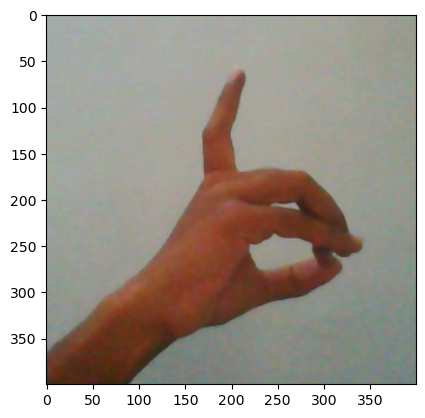

In [120]:
show_image(img)

## Flipping

In [121]:
def flip_image(image):
    return cv.flip(img, 1)


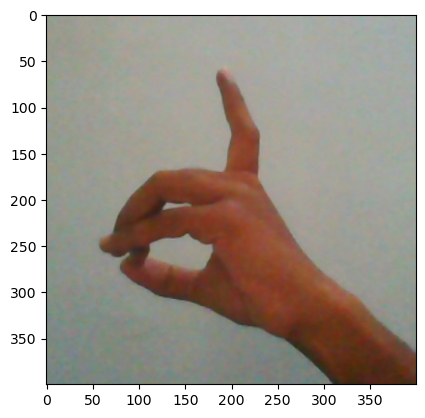

In [122]:
show_image(flip_image(img))

## Transform HSV

255


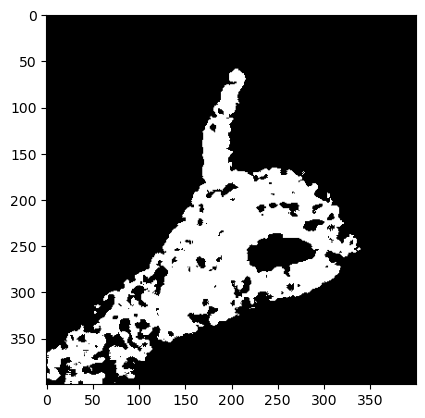

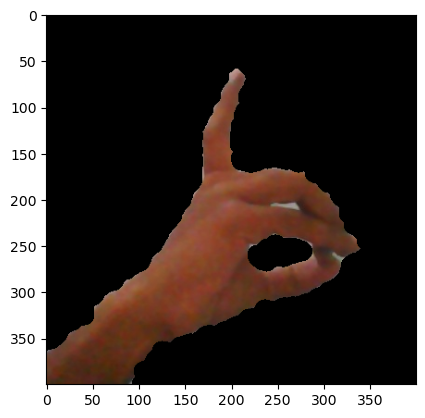

In [82]:
image_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

hsv_min = []
hsv_max = []

hsv_min.append(np.array([0, 40, 50])) # hsv(15, 60.61%, 38.82%)
hsv_max.append(np.array([10, 255,255])) # hsv(6.76, 33.33%, 83.53%)

hsv_min.append(np.array([160, 40, 50])) # hsv(15, 60.61%, 38.82%)
hsv_max.append(np.array([180, 255,255])) # hsv(6.76, 33.33%, 83.53%)

hsv_min, hsv_max = np.array(hsv_min), np.array(hsv_max)


skin_image_hsv = sum([cv.inRange(image_hsv, lower, upper) for lower, upper in zip(hsv_min, hsv_max)])
np.min(skin_image_hsv), np.max(skin_image_hsv)
show_image(skin_image_hsv)

binary = np.copy(skin_image_hsv)

binary = cv.morphologyEx(binary, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (21,21)))
binary = cv.morphologyEx(binary, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3)))
print(np.max(binary))
hand_only = np.copy(img)
hand_only[binary == 0] = 0
show_image(hand_only)




255


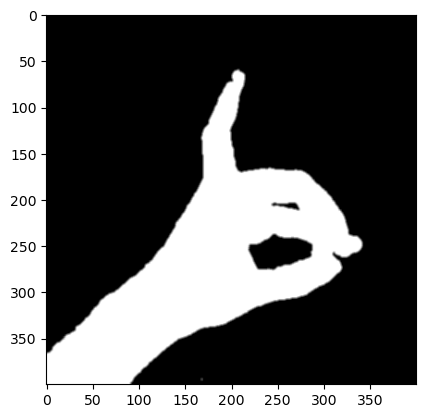

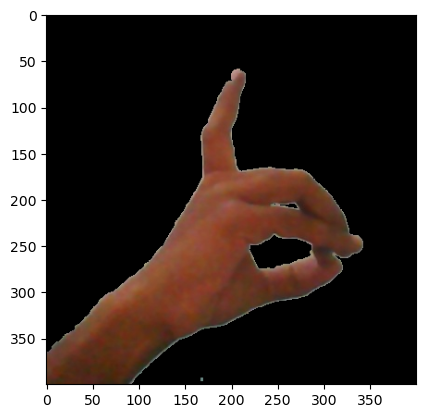

In [116]:
image_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

hsv_min = []
hsv_max = []

hsv_min.append(np.array([0, 0, 100])) # hsv(15, 60.61%, 38.82%)
hsv_max.append(np.array([180, 60,255])) # hsv(6.76, 33.33%, 83.53%)

#hsv_min.append(np.array([160, 40, 50])) # hsv(15, 60.61%, 38.82%)
#hsv_max.append(np.array([180, 255,255])) # hsv(6.76, 33.33%, 83.53%)

hsv_min, hsv_max = np.array(hsv_min), np.array(hsv_max)


skin_image_hsv = sum([cv.inRange(image_hsv, lower, upper) for lower, upper in zip(hsv_min, hsv_max)])
np.min(skin_image_hsv), np.max(skin_image_hsv)

binary = np.copy(skin_image_hsv)
binary = cv.bitwise_not(binary)


# binary = cv.morphologyEx(binary, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (21,21)))
# binary = cv.morphologyEx(binary, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3)))

binary = cv.GaussianBlur(binary, (3,3), 3)

print(np.max(binary))

show_image(binary)

hand_only = np.copy(img)
hand_only[binary == 0] = 0
show_image(hand_only)




In [117]:
def get_hand_filter(img):
    image_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

    hsv_min = []
    hsv_max = []
    
    hsv_min.append(np.array([0, 0, 100])) # hsv(15, 60.61%, 38.82%)
    hsv_max.append(np.array([180, 60,255])) # hsv(6.76, 33.33%, 83.53%)
    
    hsv_min, hsv_max = np.array(hsv_min), np.array(hsv_max)
       
    background_image_hsv = sum([cv.inRange(image_hsv, lower, upper) for lower, upper in zip(hsv_min, hsv_max)])
    np.min(skin_image_hsv), np.max(skin_image_hsv)
    
    binary = np.copy(skin_image_hsv)
    binary = cv.bitwise_not(binary)
    
    binary = cv.GaussianBlur(binary, (3,3), 3)
    return binary



In [135]:
def show_hand_filter(img):
    binary = get_hand_filter(img)
    hand_only = np.copy(img)
    hand_only[binary == 0] = 0
    show_images([img, binary, hand_only])


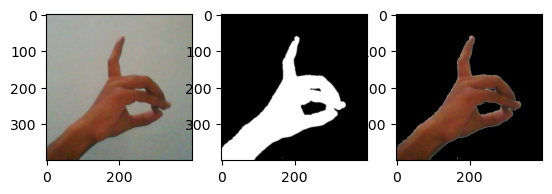

In [136]:
img = cv.imread(dataset_path + r"/Train/D/10.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

images = 

show_hand_filter(img)                 

## Gray Scale Image

In [10]:
def to_gray(image):
    return cv.cvtColor(image, cv.COLOR_RGB2GRAY)

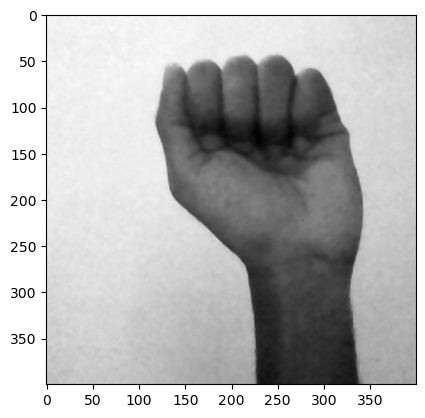

In [11]:
show_image(to_gray(img))

## Blur

In [12]:
def blur_gaussian(image):
    return cv.GaussianBlur(image, (5, 5), 2)

In [13]:
def blur_median(image):
    return cv.medianBlur(image, 5)

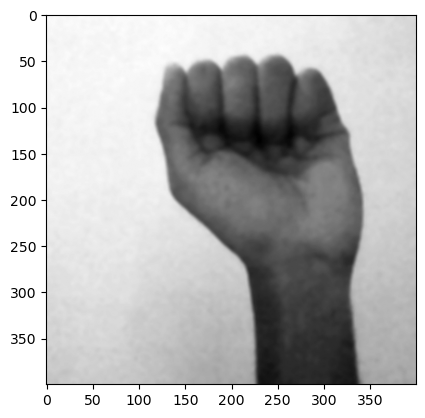

In [14]:
show_image(blur_gaussian(to_gray(img)))

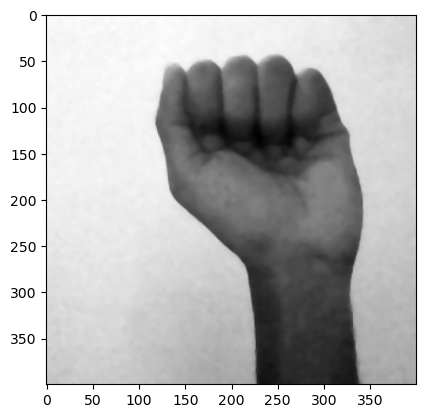

In [15]:
show_image(blur_median(to_gray(img)))

## Edge Detection

In [16]:
def detect_edges(image):
    return cv.Canny(image, 45, 60, 3)

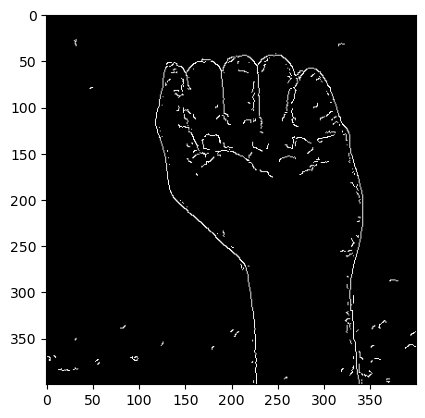

In [17]:
show_image(detect_edges(img))